In [77]:
!pip install split-folders
!pip install torch-summary
!pip install opencv-python

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [78]:
# Import essential libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy # A module that provides functions for creating copies of objects, useful for avoiding unintended modifications to variables.
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [79]:
labels_df = pd.read_csv('metadata.csv')
print(labels_df.head().to_markdown())

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


In [80]:
labels_df.shape


(4600, 6)

# Introduction

Overall, deep learning has the potential to revolutionize brain tumor detection and diagnosis. By leveraging the power of neural networks, we can enhance the accuracy, efficiency, and understanding of brain tumor imaging, ultimately leading to improved patient care and outcomes in the field of neuro-oncology.

# Objective

develop a Convolutional Neural Network (CNN) using the PyTorch framework that can accurately detect and classify Brain Tumors from MRI scans. The CNN will be trained on a large dataset of labeled brain tumor images to learn the patterns and features associated with different tumor types. The study aims to achieve high accuracy in tumor detection and classification, providing a valuable tool for healthcare professionals in the field of neuro-oncology. The ultimate goal is to improve the efficiency and accuracy of brain tumor diagnosis, enabling timely and appropriate treatment planning for patients.

# Split Dataset

80% - Training data, 20% - Validation

In [81]:
import os
import shutil
from PIL import Image
import pathlib
import splitfolders

# Function to convert non-JPEG images to JPEG format and organize them into class subdirectories
def convert_images_and_organize(input_dir, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Define class subdirectories in the output directory
    healthy_output_dir = os.path.join(output_dir, "Healthy")
    tumor_output_dir = os.path.join(output_dir, "Brain Tumor")
    os.makedirs(healthy_output_dir, exist_ok=True)
    os.makedirs(tumor_output_dir, exist_ok=True)
    
    # Iterate through all files in the input directory
    for root, dirs, files in os.walk(input_dir):
        for filename in files:
            if filename.lower().endswith((".jpg", ".jpeg")):
                print(f"Processing JPEG file: {filename}")
                # Determine the class of the image based on its directory
                if "healthy" in root.lower() or any("healthy" in d.lower() for d in dirs):
                    # Move the JPEG image to the Healthy subdirectory
                    src_path = os.path.join(root, filename)
                    dest_path = os.path.join(healthy_output_dir, filename)
                    print(f"Moving file to {dest_path}")
                    shutil.move(src_path, dest_path)
                elif "tumor" in root.lower() or any("tumor" in d.lower() for d in dirs):
                    # Move the JPEG image to the Brain Tumor subdirectory
                    src_path = os.path.join(root, filename)
                    dest_path = os.path.join(tumor_output_dir, filename)
                    print(f"Moving file to {dest_path}")
                    shutil.move(src_path, dest_path)
                else:
                    print(f"Warning: Unrecognized class for file {filename}")
            else:
                try:
                    print(f"Processing non-JPEG file: {filename}")
                    # Open the image
                    img_path = os.path.join(root, filename)
                    img = Image.open(img_path)
                    
                    # Convert the image to JPEG format
                    jpeg_path = os.path.join(output_dir, os.path.splitext(filename)[0] + ".jpg")
                    img.convert("RGB").save(jpeg_path, "JPEG")
                    
                    # Determine the class of the image based on its directory
                    if "healthy" in root.lower() or any("healthy" in d.lower() for d in dirs):
                        # Move the JPEG image to the Healthy subdirectory
                        dest_path = os.path.join(healthy_output_dir, os.path.basename(jpeg_path))
                        print(f"Moving file to {dest_path}")
                        shutil.move(jpeg_path, dest_path)
                    elif "tumor" in root.lower() or any("tumor" in d.lower() for d in dirs):
                        # Move the JPEG image to the Brain Tumor subdirectory
                        dest_path = os.path.join(tumor_output_dir, os.path.basename(jpeg_path))
                        print(f"Moving file to {dest_path}")
                        shutil.move(jpeg_path, dest_path)
                    else:
                        print(f"Warning: Unrecognized class for file {filename}")
                except Exception as e:
                    print(f"Error processing file {filename}: {e}")

# Specify the paths for input directory and output directory
input_dir = 'C:\\Users\\sherr\\Desktop\\NTU Y4S1\\FYP\\CNN Pytorch\\Brain Tumor Data Set'
output_dir = 'C:\\Users\\sherr\\Desktop\\NTU Y4S1\\FYP\\CNN Pytorch\\Brain Tumor Data Set JPEG'

# Convert non-JPEG images to JPEG format and organize them into class subdirectories
convert_images_and_organize(input_dir, output_dir)

# After conversion, update the data directory path
data_dir_jpeg = pathlib.Path(output_dir)

# Define the new directories for training and validation sets
train_dir = 'C:\\Users\\sherr\\Desktop\\NTU Y4S1\\FYP\\CNN Pytorch\\brain\\train'
val_dir = 'C:\\Users\\sherr\\Desktop\\NTU Y4S1\\FYP\\CNN Pytorch\\brain\\val'

# Filter out non-JPEG files from the training and validation directories
for directory in [train_dir, val_dir]:
    for root, dirs, files in os.walk(directory):
        for file in files:
            if not file.lower().endswith((".jpg", ".jpeg")):
                os.remove(os.path.join(root, file))

# Split the dataset into train, validation, and test sets
splitfolders.ratio(data_dir_jpeg, output='C:\\Users\\sherr\\Desktop\\NTU Y4S1\\FYP\\CNN Pytorch\\brain', seed=20, ratio=(0.8, 0.2))

# Print out the number of files in the training and validation directories
train_file_count = sum(len(files) for _, _, files in os.walk(train_dir))
val_file_count = sum(len(files) for _, _, files in os.walk(val_dir))
print(f"Number of files in training directory: {train_file_count}")
print(f"Number of files in validation directory: {val_file_count}")


Processing non-JPEG file: Cancer (1).png
Moving file to C:\Users\sherr\Desktop\NTU Y4S1\FYP\CNN Pytorch\Brain Tumor Data Set JPEG\Brain Tumor\Cancer (1).jpg
Processing non-JPEG file: Cancer (1).tif
Moving file to C:\Users\sherr\Desktop\NTU Y4S1\FYP\CNN Pytorch\Brain Tumor Data Set JPEG\Brain Tumor\Cancer (1).jpg
Processing non-JPEG file: Cancer (10).tif
Moving file to C:\Users\sherr\Desktop\NTU Y4S1\FYP\CNN Pytorch\Brain Tumor Data Set JPEG\Brain Tumor\Cancer (10).jpg
Processing non-JPEG file: Cancer (11).tif
Moving file to C:\Users\sherr\Desktop\NTU Y4S1\FYP\CNN Pytorch\Brain Tumor Data Set JPEG\Brain Tumor\Cancer (11).jpg
Processing non-JPEG file: Cancer (12).tif
Moving file to C:\Users\sherr\Desktop\NTU Y4S1\FYP\CNN Pytorch\Brain Tumor Data Set JPEG\Brain Tumor\Cancer (12).jpg
Processing non-JPEG file: Cancer (13).tif
Moving file to C:\Users\sherr\Desktop\NTU Y4S1\FYP\CNN Pytorch\Brain Tumor Data Set JPEG\Brain Tumor\Cancer (13).jpg
Processing non-JPEG file: Cancer (14).tif
Moving f

Copying files: 4512 files [00:52, 86.02 files/s] 

Number of files in training directory: 4472
Number of files in validation directory: 2186


# Conversion into binary image
Convert the gray-scale image into binary image by processing the image with a threshold value: pixels equal to or lower than 127 will be pushed down to 0 and greater will be pushed up to 255. Such process is compulsory as later transformation processes takes in binary images.

In [82]:
def binarization(x):
    return torch.where(x >= 0.5, torch.tensor(1.0), torch.tensor(0.0))

# Image Augmentation

Prepares images for consumption by a neural network model. It first resizes the images to a fixed size, then applies random augmentations such as horizontal and vertical flipping, and random rotation to increase the diversity of the training data. Finally, it converts the images to PyTorch tensors and normalizes them using precomputed mean and standard deviation values to ensure consistent training.

In [83]:
# # Convert images to JPEG format during preprocessing
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(30),
#     transforms.Grayscale(num_output_channels=1),  # Convert to single-channel grayscale
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485], std=[0.229]),  # Normalize the binarized image
#     # ThresholdTransform(threshold=0.5),  # Binarize the grayscale image
#     transforms.Lambda(binarization)  # Apply binarization
# ])

# Define the transformation pipeline for both training and validation sets
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.Grayscale(num_output_channels=1),  # Convert to single-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Normalize
    transforms.Lambda(binarization)  # Apply binarization
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),
    transforms.Lambda(binarization)
])

# Define custom dataset objects

This code sets up custom dataset objects for training and validation data using the ImageFolder class from torchvision.datasets. It loads images from specified directories (train and val directories within data_dir) and applies the transformation pipeline (transform=transform) defined earlier to preprocess the images. The transform parameter ensures that the same transformations are applied consistently to both training and validation data, which is crucial for maintaining consistency during model training and evaluation.

In [84]:
# Define the custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = torchvision.datasets.ImageFolder(root=root_dir, transform=self.transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

# Create custom dataset objects for training and validation
train_set = CustomDataset(train_dir, transform=train_transform)
val_set = CustomDataset(val_dir, transform=val_transform)

In [85]:
# # Define the custom dataset objects for training and validation
# train_set = torchvision.datasets.ImageFolder(train_dir, transform=transform)
# val_set = torchvision.datasets.ImageFolder(val_dir, transform=transform)

# Print out the transformation pipeline applied to the training set
print("Transformation pipeline applied to the training set:")
print(train_set.transform)

# Print out the transformation pipeline applied to the validation set
print("\nTransformation pipeline applied to the validation set:")
print(val_set.transform)



Transformation pipeline applied to the training set:
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    Grayscale(num_output_channels=1)
    ToTensor()
    Normalize(mean=[0.485], std=[0.229])
    Lambda()
)

Transformation pipeline applied to the validation set:
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=1)
    ToTensor()
    Normalize(mean=[0.485], std=[0.229])
    Lambda()
)


Total images in train_set: 4472
Binarized images in train_set: 4454
Non-binarized images in train_set: 18
Sample 1: Binarized? True
Sample 2: Binarized? True
Sample 3: Binarized? True
Sample 4: Binarized? True
Sample 5: Binarized? True


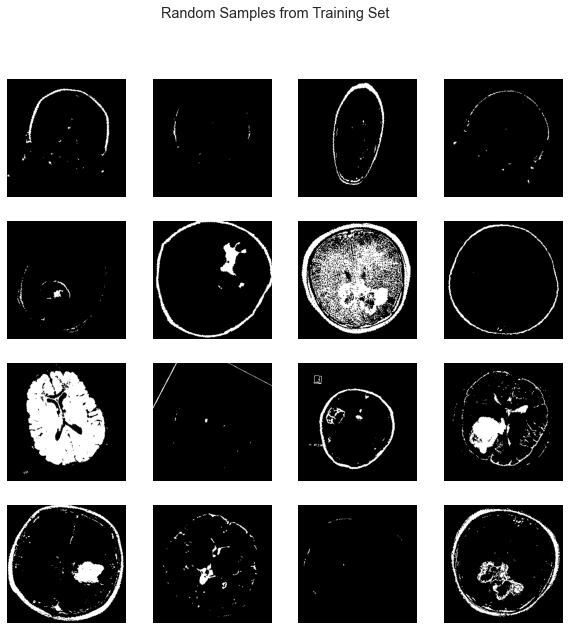

In [86]:
# Define a function to check if an image is binarized
def is_binarized(img):
    unique_values = torch.unique(img)
    return len(unique_values) == 2

# Count the number of binarized and non-binarized images in the training set
binarized_count = 0
total_count = len(train_set)

# Iterate through the training set to check for binarization
for i in range(total_count):
    img, _ = train_set[i]
    if is_binarized(img):
        binarized_count += 1

# Print out the summary
print(f"Total images in train_set: {total_count}")
print(f"Binarized images in train_set: {binarized_count}")
print(f"Non-binarized images in train_set: {total_count - binarized_count}")

# Iterate over a few random samples from the training set and print whether they are binarized
for i in range(5):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    print(f"Sample {i+1}: Binarized? {is_binarized(img)}")

# Plot a few random samples from the training set
plt.figure(figsize=(10, 10))
for i in range(16):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    plt.subplot(4, 4, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle('Random Samples from Training Set')
plt.show()

# Visualization of images

This code segment visualizes a set of random images from the training dataset. It iterates through a grid of subplots, selects random samples from the training dataset, retrieves their corresponding labels, and displays them with their class names as titles. The images are converted from PyTorch tensors to NumPy arrays for visualization, and their pixel values are clipped to ensure they fall within the valid range of [0, 1]. Finally, the overall title of the plot is set to "Brain Images".

Total images in train_set: 4472
Binarized images in train_set: 4453
Non-binarized images in train_set: 19


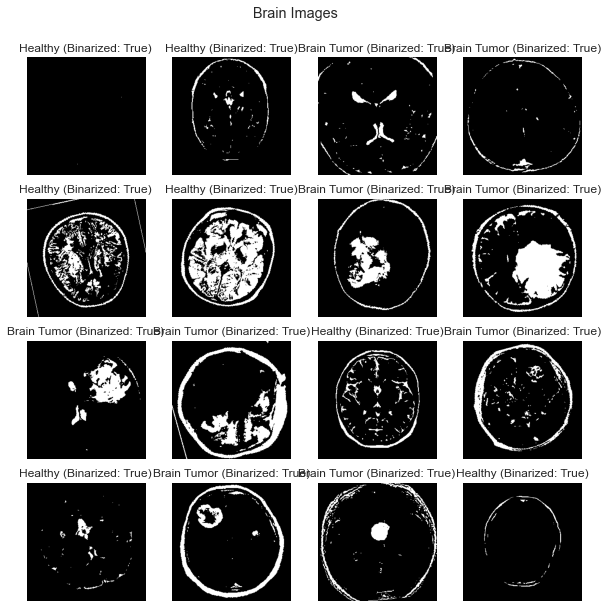

In [87]:
# Dictionary to map class labels to their corresponding class names
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
} 

# Define a function to check if an image is binarized
def is_binarized(img):
    unique_values = torch.unique(img)
    return len(unique_values) == 2

# Count the number of binarized and non-binarized images in the training set
binarized_count = 0
total_count = len(train_set)

# Iterate through the training set to check for binarization
for i in range(total_count):
    img, _ = train_set[i]
    if is_binarized(img):
        binarized_count += 1

# Print out the summary
print(f"Total images in train_set: {total_count}")
print(f"Binarized images in train_set: {binarized_count}")
print(f"Non-binarized images in train_set: {total_count - binarized_count}")

# Create a new figure for plotting with a specified size
figure = plt.figure(figsize=(10, 10))

# Define the number of columns and rows for subplots
cols, rows = 4, 4

# Loop to generate subplots for visualizing images
for i in range(1, cols * rows + 1):
    # Generate a random sample index within the range of the training set
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    
    # Retrieve the image and its corresponding label using the sample index
    img, label = train_set[sample_idx]
    
    # Check if the image is binarized
    binarized = is_binarized(img)
    
    # If the image is not binarized, skip to the next iteration
    if not binarized:
        continue
    
    # Add a subplot to the figure
    figure.add_subplot(rows, cols, i)
    
    # Set the title of the subplot to the corresponding class name
    plt.title(f'{CLA_label[label]} (Binarized: {binarized})')
    
    # Turn off axis labels for cleaner visualization
    plt.axis("off")
    
    # Convert the PyTorch tensor image to a NumPy array and transpose its dimensions
    img_np = img.numpy()
    
    # Clip pixel values to the valid range of [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    
    # Display the image in the subplot
    plt.imshow(img_np.squeeze(), cmap='gray')
    
    # Set the overall title for the plot
    plt.suptitle('Brain Images', y=0.95)

# Show the plot with all the subplots
plt.show()


In this code, DataLoader is used from the torch.utils.data module to create iterators for loading batches of data from the training and validation sets. These iterators will be used during the training and evaluation of a neural network model. The batch_size parameter determines the number of samples in each batch, and shuffle is set to True to shuffle the data at the beginning of each epoch to improve training effectiveness. The num_workers parameter specifies the number of subprocesses to use for data loading, which can speed up data loading by utilizing multiple CPU cores.

In [88]:
# Define the batch size for loading data
batch_size = 64

# Create a DataLoader for the training set
# DataLoader is used to load batches of data from the dataset during training
# train_set: the dataset to load
# batch_size: number of samples in each batch
# shuffle: set to True to shuffle the data at every epoch
# num_workers: number of subprocesses to use for data loading
# pin_memory: set to True if using CUDA tensors for faster data transfer to GPU
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation set
# Similar to train_loader, but loads data from the validation set
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [89]:
import numpy as np

def create_image_array(loader):
    # Initialize an empty list to store the images
    image_list = []

    # Iterate over the loader to accumulate images
    for images, _ in loader:
        for img in images:
            # Convert PyTorch tensor to NumPy array and add it to the list
            image_list.append(img.numpy())

    # Convert the list of arrays to a single NumPy array
    images_array = np.array(image_list)

    return images_array

# Create NumPy arrays for training and validation images
train_images_array = create_image_array(train_loader)
val_images_array = create_image_array(val_loader)

# Print the shape of the resulting arrays
print("Shape of the train images array:", train_images_array.shape)
print("Shape of the validation images array:", val_images_array.shape)


Shape of the train images array: (4472, 1, 256, 256)
Shape of the validation images array: (2186, 1, 256, 256)


In [90]:
import os

def readData(*data_paths):
    ex_data = {}
    for data_path in data_paths:
        # Iterate through each data path
        for root, dirs, files in os.walk(data_path):
            for file in files:
                # Assuming each image file's name contains the experimental data
                # Extract the relevant information from the file name
                # For example, if the filename is 'image_001_experiment_0.jpg', you can extract '0'
                filename_parts = file.split('_')
                if len(filename_parts) >= 3 and filename_parts[-1].endswith('.jpg'):
                    # Extract the experiment data (assuming it's the last part of the filename)
                    experiment_data = int(filename_parts[-2])  # Adjust the index based on your filename structure
                    # Use the filename (without extension) as the key and experiment data as the value
                    filename = os.path.splitext(file)[0]
                    ex_data[filename] = experiment_data
    return ex_data

train_data_path = train_dir
val_data_path = val_dir

ex_data_train = readData(train_data_path)
ex_data_val = readData(val_data_path)


In [91]:
def rcImgProcessLs(train_images_array, ex_data, img_height=256, img_width=256):
    try:
        datasets_N = np.shape(train_images_array)[0]  # The number of images in the train & test dataset
        output_arr = np.zeros((datasets_N, int(img_height * img_width / 3)), dtype=np.float32)  # The output array definition

        for k in range(datasets_N):
            # Assuming image names are either 'Cancer' or 'Not cancer'
            filename = "Cancer" if k % 2 == 0 else "Not cancer"
            if filename in ex_data:
                # Access experimental data corresponding to the filename
                experiment_data = ex_data[filename]
                for i in range(0, img_height * img_width, 3):
                    id = int(train_images_array[k, i + 2] + 2 * train_images_array[k, i + 1] + 4 * train_images_array[k, i])
                    output_arr[k] = experiment_data[id]

        print("Finished reservoir computing (lineshape) using experimental memristive devices on training data")

        return output_arr
    except Exception as e:
        print(f"Error processing images: {e}")
        return None


In [92]:
if ex_data_train is not None and ex_data_val is not None:
    # Call rcImgProcessLs() function after loading train images
    processed_train_images = rcImgProcessLs(train_images_array, ex_data_train)

    # Call rcImgProcessLs() function after loading validation images
    processed_val_images = rcImgProcessLs(val_images_array, ex_data_val)

    # Print the shape of the resulting processed arrays
    print("Shape of the processed train images array:", processed_train_images.shape)
    print("Shape of the processed validation images array:", processed_val_images.shape)
else:
    print("Failed to load experimental data. Check for errors in the readData() function.")

Finished reservoir computing (lineshape) using experimental memristive devices on training data
Finished reservoir computing (lineshape) using experimental memristive devices on training data
Shape of the processed train images array: (4472, 21845)
Shape of the processed validation images array: (2186, 21845)


This code iterates over the dictionary containing keys "Training data" and "Validation data", where the values are DataLoader objects (train_loader and val_loader). For each DataLoader, it iterates over batches of data, extracting input data (X) and labels (y). For each batch, it prints the key indicating whether it's training or validation data, as well as the shape of the input data (X) and the shape and data type of the labels (y). The break statement is used to exit the inner loop after processing the first batch, ensuring that only one batch of data is printed for each DataLoader.

In [93]:
# print shape for Training data and Validation data
# Where X is train_loader and y is val_loader
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 1, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 1, 256, 256])
Shape of y: torch.Size([64]) torch.int64



# Convolutional layer parameters

This function is designed to calculate the output size of a convolutional layer in a neural network given the input dimensions (hin, win) and the convolutional layer's parameters (conv). The output size is computed using the formula for convolution output size, taking into account parameters such as kernel size, stride, padding, and dilation. If a pooling size is specified, the output size is adjusted accordingly. The function returns the computed output height and width as integers.

In [94]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters.'''
# Define a function named findConv2dOutShape that takes input dimensions (hin, win), a convolutional layer (conv), and an optional pooling size (pool)
def findConv2dOutShape(hin, win, conv, pool=2):
    # Extract convolutional layer parameters
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation

    # Compute output height and width using the formula for convolution output size
    hout = np.floor((hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
    wout = np.floor((win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)

    # If pooling is specified, adjust output size by dividing by the pooling size
    if pool:
        hout /= pool
        wout /= pool
    
    # Return the computed output height and width
    return int(hout), int(wout)


This code defines a CNN architecture with multiple convolutional layers followed by fully connected layers for tumor classification. The __init__ method initializes the network's architecture, and the forward method defines the forward pass computation.

The __init__ method:

Initializes the superclass (nn.Module) and unpacks input parameters such as input shape, number of filters, number of neurons in the fully connected layers, number of output classes, and dropout rate.
Defines convolutional layers (self.conv1, self.conv2, self.conv3, self.conv4) with specified kernel sizes and calculates the output shape after each layer using the findConv2dOutShape function.
Calculates the number of features to be flattened before the fully connected layers.
Defines fully connected layers (self.fc1, self.fc2) with specified numbers of neurons.

The **forward** method:

Performs the forward pass computation:
Applies convolutional layers (self.conv1 to self.conv4) followed by ReLU activation and max pooling.
Flattens the output tensor.
Applies fully connected layers (self.fc1, self.fc2) with ReLU activation and dropout.
Returns the log softmax output for classification.

In [95]:
class CNN_TUMOR(nn.Module):
    
    # Constructor method for initializing the CNN_TUMOR class
    def __init__(self, params):
        
        # Call the constructor of the superclass (nn.Module)
        super(CNN_TUMOR, self).__init__()
    
        # Unpack input parameters
        Cin, Hin, Win = params["shape_in"]  # Number of channels, height, width of input image
        init_f = params["initial_filters"]  # Initial number of filters in conv layers
        num_fc1 = params["num_fc1"]  # Number of neurons in the first fully connected layer
        num_classes = params["num_classes"]  # Number of output classes (e.g., types of tumor)
        self.dropout_rate = params["dropout_rate"]  # Dropout rate for regularization
        
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h, w = findConv2dOutShape(Hin, Win, self.conv1)  # Calculate output shape after this layer
        
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv2)  # Adjust h, w for output shape
        
        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv3)  # Further adjust h, w for output shape
        
        # Define the fourth convolutional layer
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv4)  # Final adjustment for output shape
        
        # Calculate the number of features to be flattened before the fully connected layer
        self.num_flatten = h * w * 8 * init_f
        
        # Define the first fully connected layer
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        
        # Define the second fully connected layer (output layer)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    # Define the forward pass
    def forward(self, X):
        # Pass input through the first convolutional layer, then apply ReLU and max pooling
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        
        # Second conv layer
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        
        # Third conv layer
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        
        # Fourth conv layer
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        
        # Flatten the output for the fully connected layer
        X = X.view(-1, self.num_flatten)
        
        # First fully connected layer with ReLU activation
        X = F.relu(self.fc1(X))
        
        # Apply dropout for regularization
        X = F.dropout(X, self.dropout_rate)
        
        # Final fully connected layer
        X = self.fc2(X)
        
        # Apply log softmax on the output to get log probabilities for each class
        return F.log_softmax(X, dim=1)


 It consists of convolutional layers for feature extraction followed by fully connected layers for classification. Additionally, it incorporates dropout regularization to prevent overfitting during training.

In [96]:
# Define the parameters for the CNN model
params_model = {
    "shape_in": (1, 256, 256),  # Input image shape: 1 channel, 256x256 pixels
    "initial_filters": 8,       # Number of filters in the first conv layer
    "num_fc1": 100,             # Number of neurons in the first fully connected layer
    "dropout_rate": 0.25,       # Dropout rate for regularization to prevent overfitting
    "num_classes": 2            # Number of output classes (e.g., tumor or no tumor)
}

# Instantiate the CNN_TUMOR model with the defined parameters
cnn_model = CNN_TUMOR(params_model)

# Determine whether a GPU with CUDA support is available; use CPU otherwise
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transfer the model to the selected device (GPU or CPU)
model = cnn_model.to(device)

In [97]:
# Model Summary for CNN Model
summary(cnn_model, input_size=(1, 256, 256),device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            80
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,086
Trainable params: 1,279,086
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            80
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,086
Trainable params: 1,279,086
Non-trainable params: 0

This line of code initializes a loss function for training a neural network. Specifically, it creates an instance of the Negative Log Likelihood Loss function (nn.NLLLoss) from the PyTorch nn module.

Explanation:

nn.NLLLoss: Negative Log Likelihood Loss is commonly used for classification problems, especially when the output of the network is a probability distribution over classes (often achieved through applying a log softmax activation function to the output layer). It measures the negative log likelihood of the true class given the predicted probabilities. In other words, it penalizes models more heavily for confidently wrong predictions.

reduction="sum": This argument specifies how the loss should be aggregated across all samples in a batch. Setting it to "sum" means that the losses from all samples in the batch will be summed up to get the total loss. Other possible values for reduction include "mean" (calculate the mean of the losses) and "none" (do not perform any reduction).

So, loss_func will be used to compute the loss during training, summing up the losses across all samples in a batch to get the total loss.

In [98]:
loss_func = nn.NLLLoss(reduction="sum")


# Optimizing 

optim.Adam: Adam is an optimization algorithm that is well-suited for training deep neural networks. It computes adaptive learning rates for each parameter based on estimates of the first and second moments of the gradients. optim.Adam is an implementation of the Adam algorithm provided by PyTorch's optim module.

cnn_model.parameters(): This method of cnn_model returns an iterator over all parameters (tensors) of the model that require gradients, which are the parameters we want to optimize during training.

lr=3e-4: This argument specifies the learning rate for the Adam optimizer. The learning rate determines the size of the step that the optimizer takes while updating the model parameters during training. Here, it's set to 3e-4 (0.0003).

ReduceLROnPlateau: This is a learning rate scheduler provided by PyTorch. It dynamically adjusts the learning rate during training based on the validation loss. If the validation loss stops improving, it reduces the learning rate to help the optimizer converge better.

mode='min': This argument specifies that the scheduler should monitor the quantity (validation loss) to be minimized.

factor=0.5: This argument specifies the factor by which the learning rate will be reduced. Here, it's set to 0.5, meaning the learning rate will be halved when triggered.

patience=20: This argument specifies the number of epochs with no improvement in the monitored quantity (validation loss) after which the learning rate will be reduced.

verbose=1: This argument controls the verbosity of the output. If set to 1, it prints a message to stdout when the learning rate is changed.

In summary, the optimizer (opt) is responsible for updating the model parameters during training using the Adam optimization algorithm with a specified learning rate. The learning rate scheduler (lr_scheduler) adjusts the learning rate dynamically based on the validation loss, aiming to improve the model's performance during training.

In [99]:
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

get_lr(opt):

This function retrieves the current learning rate from the optimizer.
It takes an optimizer (opt) as input.

Inside the function:

It iterates over the param_groups attribute of the optimizer.
Each param_group is a dictionary containing optimizer parameters, including the learning rate.
It returns the learning rate found in the first parameter group.

loss_batch(loss_func, output, target, opt=None):

This function computes the loss value and a performance metric (e.g., accuracy) for a batch of data.

It takes the following inputs:

loss_func: The loss function to compute the loss.
output: The model's output tensor.
target: The target labels tensor.
opt (optional): The optimizer object for performing backpropagation and optimization. If provided, it will update the model's parameters.

Inside the function:

It computes the loss using the specified loss_func.
It calculates the predicted classes by finding the indices of the maximum values along the class dimension.
It computes the performance metric by comparing the predicted classes with the target labels.
If an optimizer is provided (opt is not None), it performs backpropagation, zeros the gradients, and updates the model's parameters.

loss_epoch(model, loss_func, dataset_dl, opt=None):

This function computes the average loss value and performance metric for the entire dataset (an epoch).

It takes the following inputs:

model: The neural network model.
loss_func: The loss function used to compute the loss.
dataset_dl: The dataloader for the dataset.
opt (optional): The optimizer object. If provided, it will be used in loss_batch to perform backpropagation and parameter updates.

Inside the function:

It initializes variables run_loss and t_metric to accumulate the total loss and performance metric.
It iterates over batches of data from the dataset_dl.
For each batch, it moves the batch data to the appropriate device (e.g., GPU), computes the model's output, and calculates the loss and metric using loss_batch.
It accumulates the loss and metric values across all batches.

Finally, it computes the average loss and metric values by dividing the accumulated values by the total number of samples in the dataset.
These functions are essential components for training a neural network model. They facilitate the computation of loss values, performance metrics, and updating model parameters during the training process.

In [100]:
# Function to get the current learning rate of the optimizer
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value and performance metric per batch of data
def loss_batch(loss_func, output, target, opt=None):
    # Calculate the loss using the specified loss function
    loss = loss_func(output, target)
    # Predicted classes are obtained by finding the index of the maximum value along the specified dimension (usually the class dimension)
    pred = output.argmax(dim=1, keepdim=True)
    # Compute the performance metric, which is the number of correct predictions in the batch
    metric_b = pred.eq(target.view_as(pred)).sum().item()

    # If an optimizer is provided, perform backpropagation and optimization steps
    if opt is not None:
        opt.zero_grad()  # Zero the gradients
        loss.backward()  # Compute gradients via backpropagation
        opt.step()  # Update model parameters based on gradients

    return loss.item(), metric_b  # Return the loss value and performance metric for the batch

# Compute the loss value and performance metric for the entire dataset (epoch)
def loss_epoch(model, loss_func, dataset_dl, opt=None):
    run_loss = 0.0  # Running loss accumulator
    t_metric = 0.0  # Total performance metric accumulator
    len_data = len(dataset_dl.dataset)  # Total number of samples in the dataset

    # Internal loop over the dataset
    for xb, yb in dataset_dl:
        # Move batch data to the device (e.g., GPU)
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)  # Get model output
        # Compute the loss and performance metric for the batch
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        run_loss += loss_b  # Accumulate the running loss

        if metric_b is not None:  # If a metric is computed
            t_metric += metric_b  # Accumulate the total metric value
    
    # Calculate the average loss value and metric value across the entire dataset
    loss = run_loss / float(len_data)
    metric = t_metric / float(len_data)

    return loss, metric  # Return the average loss and metric values for the epoch


The Train_Val function is responsible for training and evaluating a neural network model over a specified number of epochs.

It takes the model to be trained, a dictionary params containing various training parameters, and an optional verbose flag to control printing progress during training.

Inside the function:

The parameters are extracted from the params dictionary.

- Loss and metric history dictionaries are initialized to track training and validation performance over epochs.
- A deep copy of the model's weights is made to store the best performing model.
- The training loop runs for the specified number of epochs.

In each epoch:

- The model is trained (model.train()) and evaluated (model.eval()).
- Training and validation losses and metrics are computed using the loss_epoch function.
- If the validation loss improves, the model weights are copied and saved as the best performing model.
- Learning rate adjustments are made using the learning rate scheduler (lr_scheduler.step()).
- Optionally, if the learning rate changes, the best model weights are reloaded.
- If verbose is True, progress information is printed.

After training, the best model weights are loaded, and the trained model, loss history, and metric history are returned.
This function encapsulates the entire process of training and validation, making it easier to manage and monitor the training progress of a neural network model.


In [101]:
def Train_Val(model, params, verbose=False):
    # Extract parameters from the params dictionary
    epochs = params["epochs"]  # Number of epochs for training
    loss_func = params["f_loss"]  # Loss function
    opt = params["optimiser"]  # Optimizer (e.g., Adam)
    train_dl = params["train"]  # DataLoader for training dataset
    val_dl = params["val"]  # DataLoader for validation dataset
    lr_scheduler = params["lr_change"]  # Learning rate scheduler
    weight_path = params["weight_path"]  # Path to save the best model weights
    
    # Initialize dictionaries to store loss and metric history
    loss_history = {"train": [], "val": []}  # Loss history for training and validation
    metric_history = {"train": [], "val": []}  # Metric history for training and validation
    
    # Create a deep copy of the model's weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict()) 
    
    # Initialize the best loss to a large value
    best_loss = float('inf')

    # Loop over epochs
    for epoch in tqdm(range(epochs)):  # tqdm provides a progress bar
        
        # Get the current learning rate
        current_lr = get_lr(opt)
        if verbose:
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        # Train the model
        model.train()  # Set the model to training mode
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        # Collect training losses and metrics
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # Evaluate the model on the validation set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient computation during evaluation
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        
        # Store the weights if the validation loss improves
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            # Save the best model weights to a file
            torch.save(model.state_dict(), weight_path)
            if verbose:
                print("Copied best model weights!")
        
        # Collect validation losses and metrics
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # Adjust learning rate based on the validation loss
        lr_scheduler.step(val_loss)
        # Reload the best model weights if learning rate is changed
        if current_lr != get_lr(opt):
            if verbose:
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
        
        if verbose:
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # Load the best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history


- params_train: This dictionary contains various parameters required for training and evaluation of the CNN model. Here's a breakdown of each parameter:
- "train": The DataLoader for the training dataset. It contains batches of training samples.
- "val": The DataLoader for the validation dataset. It contains batches of validation samples.
- "epochs": The number of epochs (iterations over the entire dataset) for training the model. (works like a for-loop)
- "optimiser": The optimizer used for updating the model parameters during training. In this case, it's Adam optimizer with a learning rate of 3e-4 (lr=3e-4).
- "lr_change": The learning rate scheduler. It adjusts the learning rate dynamically during training based on the validation loss. Here, it's an instance of ReduceLROnPlateau scheduler, which reduces the learning rate by a factor of 0.5 if the validation loss does not improve for 20 epochs.
- "f_loss": The loss function used for computing the loss during training. It's Negative Log Likelihood Loss (nn.NLLLoss) with sum reduction.
- "weight_path": The path where the best model weights will be saved. In this case, it's set to "weights.pt".
- cnn_model, loss_hist, metric_hist = Train_Val(cnn_model, params_train): This line calls the Train_Val function to train and validate the CNN model. It passes the CNN model (cnn_model) and the training parameters (params_train). After training, it returns the trained model (cnn_model), the loss history (loss_hist), and the metric history (metric_hist).

In [102]:
# Define various parameters used for training and evaluation of a cnn_model
params_train = {
    "train": train_loader,  # DataLoader for training dataset
    "val": val_loader,  # DataLoader for validation dataset
    "epochs": 60,  # Number of epochs for training
    "optimiser": optim.Adam(cnn_model.parameters(), lr=3e-4),  # Adam optimizer with learning rate 3e-4
    "lr_change": ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=0),  # Learning rate scheduler
    "f_loss": nn.NLLLoss(reduction="sum"),  # Negative Log Likelihood Loss function
    "weight_path": "weights.pt",  # Path to save the best model weights
}

# Train and validate the model
cnn_model, loss_hist, metric_hist = Train_Val(cnn_model, params_train)


  0%|          | 0/60 [00:00<?, ?it/s]

- epochs = params_train["epochs"]: This line extracts the number of epochs (epochs) from the params_train dictionary. It's used to define the x-axis range for plotting the convergence history.

- fig, ax = plt.subplots(1, 2, figsize=(12, 5)): This line creates a figure (fig) and a set of subplots (ax) arranged in a single row and two columns. The total figure size is set to 12x5 inches.

sns.lineplot(...):

These lines plot the convergence history on the created subplots using Seaborn's lineplot function.
Loss:
- sns.lineplot(x=[*range(1, epochs+1)], y=loss_hist["train"], ax=ax[0], label='loss_hist["train"]'): This line plots the training loss (loss_hist["train"]) against the epoch number on the first subplot (ax[0]). It uses a label to identify the plot.
- sns.lineplot(x=[*range(1, epochs+1)], y=loss_hist["val"], ax=ax[0], label='loss_hist["val"]'): This line plots the validation loss (loss_hist["val"]) against the epoch number on the first subplot (ax[0]). It uses a label to identify the plot.

Accuracy:
- sns.lineplot(x=[*range(1, epochs+1)], y=metric_hist["train"], ax=ax[1], label='Acc_hist["train"]'): This line plots the training accuracy (metric_hist["train"]) against the epoch number on the second subplot (ax[1]). It uses a label to identify the plot.
- sns.lineplot(x=[*range(1, epochs+1)], y=metric_hist["val"], ax=ax[1], label='Acc_hist["val"]'): This line plots the validation accuracy (metric_hist["val"]) against the epoch number on the second subplot (ax[1]). It uses a label to identify the plot.

These lines of code create a figure with two subplots: one for displaying loss history and the other for displaying accuracy history. The training and validation loss and accuracy are plotted against the epoch number to visualize the convergence of the model during training.

<AxesSubplot:>

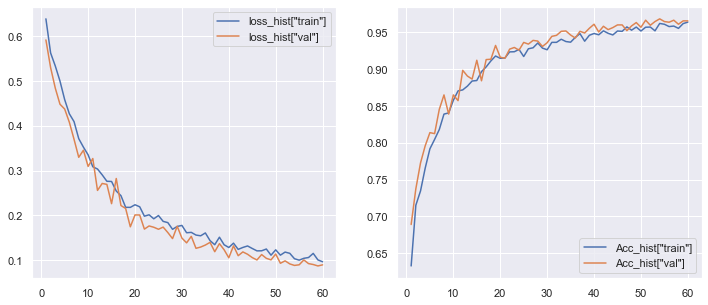

In [103]:
# Convergence History Plot
epochs = params_train["epochs"]  # Extract the number of epochs from training parameters

# Create subplots for displaying loss and accuracy history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss history
sns.lineplot(x=[*range(1, epochs+1)], y=loss_hist["train"], ax=ax[0], label='loss_hist["train"]')
sns.lineplot(x=[*range(1, epochs+1)], y=loss_hist["val"], ax=ax[0], label='loss_hist["val"]')

# Plot training and validation accuracy history
sns.lineplot(x=[*range(1, epochs+1)], y=metric_hist["train"], ax=ax[1], label='Acc_hist["train"]')
sns.lineplot(x=[*range(1, epochs+1)], y=metric_hist["val"], ax=ax[1], label='Acc_hist["val"]')


The Ture_and_Pred function takes a DataLoader (val_loader) and a model (model) as inputs. It iterates through the validation loader to get true labels (y_true) and predicted labels (y_pred) for each image. These true and predicted labels are stored in separate lists.

Inside the loop:

- Images are moved to the appropriate device (device, usually GPU) for model inference.
- True labels are converted from tensors to NumPy arrays.
- Model predictions are obtained by passing images through the model (model(images)). The torch.max function is used to get the index of the class with the highest probability (pred).
- Predicted labels are converted from tensors to NumPy arrays.
- After iterating through the validation loader, the function returns the lists of true and predicted labels.

The true and predicted labels are then used to compute the classification report using classification_report from scikit-learn, which provides precision, recall, F1-score, and support for each class.

Finally, the confusion matrix (cm) is computed using confusion_matrix from scikit-learn for error analysis.

In [104]:
# Define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0  # Initialize a counter
    y_true = []  # Create an empty list to store true labels
    y_pred = []  # Create an empty list to store predicted labels
    for images, labels in val_loader:  # Iterate through the validation loader
        images = images.to(device)  # Move images to the appropriate device (e.g., GPU)
        labels = labels.numpy()  # Convert tensor labels to numpy array
        outputs = model(images)  # Get model predictions for the images
        _, pred = torch.max(outputs.data, 1)  # Get the predicted class with maximum probability
        pred = pred.detach().cpu().numpy()  # Convert tensor predictions to numpy array
        
        # Append true and predicted labels to the respective lists
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred  # Return the true and predicted labels

# Call the function to get true and predicted labels
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

# Print classification report
print(classification_report(y_true, y_pred), '\n\n')

# Compute confusion matrix for error analysis
cm = confusion_matrix(y_true, y_pred)


              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1187
         1.0       0.96      0.96      0.96       999

    accuracy                           0.97      2186
   macro avg       0.97      0.97      0.97      2186
weighted avg       0.97      0.97      0.97      2186
 




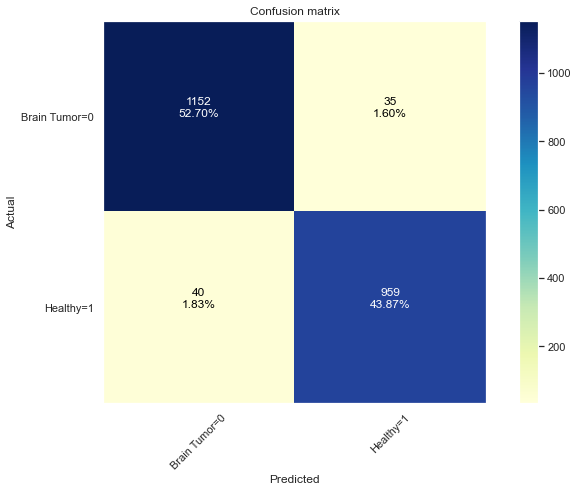

In [105]:
# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    """
    Plot the confusion matrix.

    Parameters:
        cm (numpy.ndarray): Confusion matrix.
        CLA_label (dict): Dictionary containing class labels.
        title (str): Title for the plot (default is 'Confusion matrix').
        cmap (matplotlib.colors.Colormap): Colormap for the plot (default is plt.cm.YlGnBu).
    """
    
    plt.figure(figsize=(10,7))  # Create a new figure with a specific size
    plt.grid(False)  # Turn off the grid
    plt.imshow(cm, interpolation='nearest', cmap=cmap)  # Display the confusion matrix as an image
    plt.title(title)  # Set the title of the plot
    plt.colorbar()  # Add a color bar to the plot
    tick_marks = np.arange(len(CLA_label))  # Create tick marks for the class labels

    # Set labels for ticks on x-axis and y-axis
    plt.xticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()])

    # Add text annotations for each cell in the confusion matrix
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')  # Set label for y-axis
    plt.xlabel('Predicted')  # Set label for x-axis
    plt.tight_layout()  # Adjust layout to prevent overlap of labels
    plt.show()  # Show the plot

# Call the function to display the confusion matrix
show_confusion_matrix(cm, CLA_label)
